In [172]:
%pylab inline
import pandas as pd
import json
import numpy as np
import gspread
from oauth2client.service_account import ServiceAccountCredentials
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

credentials = ServiceAccountCredentials.from_json_keyfile_name(
    '/storage/mgymrek/workspace/capillary-electrophoresis-webserver/capillaryelectrophoresis-e683d5dd37a2.json', scope)
gc = gspread.authorize(credentials)

def LoadGSheet(wks):
    data = wks.get_all_values()
    headers = data.pop(0)
    return pd.DataFrame(data, columns=headers)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['prod', 'sample', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [173]:
colordict = {
    "PlatinumGenomes": "red",
    "GIAB": "blue",
    "1000Genomes": "green"
}
sampdata = LoadGSheet(gc.open("1000GenomesRepeatValidationDatabase").worksheet("samples"))
sampdata["color"] = sampdata["SampleCollection"].apply(lambda x: colordict[x])
sampcolors = dict(zip(list(sampdata["SampleID"]), list(sampdata["color"])))

In [174]:
############### Load list of loci to consider ###########
loci = pd.read_csv('../data/csv/1000g_loci.csv')
primer_ids = set(loci["LocusID"])

In [175]:
############### Load product sizes from google sheet ###########
psdata = LoadGSheet(gc.open("1000GenomesRepeatValidationDatabase").worksheet("product size"))
psdata = psdata[psdata["PrimerID"].isin(primer_ids)][["PrimerID","SampleID","Product size"]]
psdata.columns = ["PrimerID", "SampleID","ProductSize"]
psdata["SampleID"] = psdata["SampleID"].apply(lambda x: x.strip())

# Sample product sizes
samp_prod_sizes = psdata[~psdata["SampleID"].isin(["Reference", "reference"])]
samp_prod_sizes = samp_prod_sizes[samp_prod_sizes["ProductSize"].apply(lambda x: "/" in x and x.split("/")[1].strip() != "")]
samp_prod_sizes[["prd_size_1", "prd_size_2"]] = samp_prod_sizes["ProductSize"].str.split('/', expand=True)[[0,1]].astype(float).round(0)


In [176]:
############### Load ref product sizes ###########
ref_prod_sizes = LoadGSheet(gc.open("1000GenomesRepeatValidationDatabase").worksheet("RefProductSizes"))

rmloci = ["AR","NOS1","FMR1","CNBP","chr12_131901040_T","chr12_75962280_T","chr12_92269453_T", \
    "chr15_72443969_T","chr16_58599051_A","chr16_67644335_T","chr3_54501407_T", \
    "chr4_176019003_T", "chr18_38020886_TCTA","AFF2","ARX","chr7_103989357_CCG","RUNX2"]
ref_prod_sizes = ref_prod_sizes[~ref_prod_sizes["PrimerID"].isin(rmloci)]

In [177]:
####### Check are some samples missing from our list?
print("*****Missing samples - maybe mislabeled *****")
for item in set(samp_prod_sizes["SampleID"]):
    if item not in sampcolors: print(item)

*****Missing samples - maybe mislabeled *****


In [178]:
############### Load product sizes from VCFs ###########
# load json for gangstr
with open('../data/json/gangstr_calls.json', 'r') as f:
    gangstr_calls = json.load(f)
# load json for hipstr
with open('../data/json/hipstr_calls.json', 'r') as f:
    hipstr_calls = json.load(f)

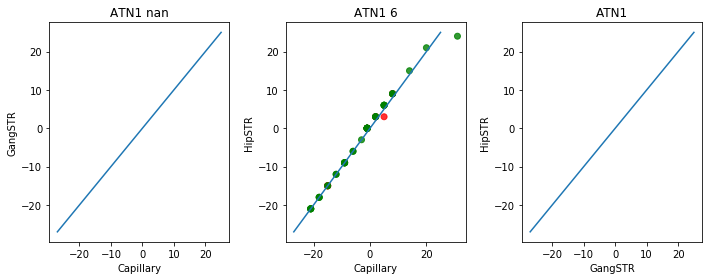

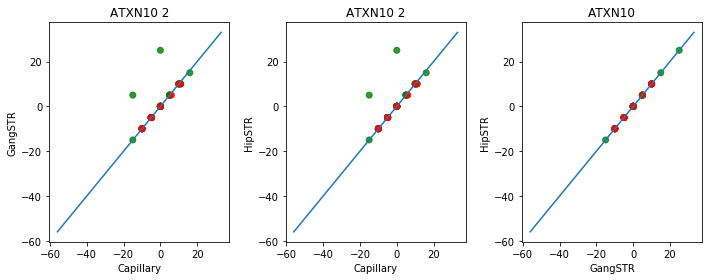

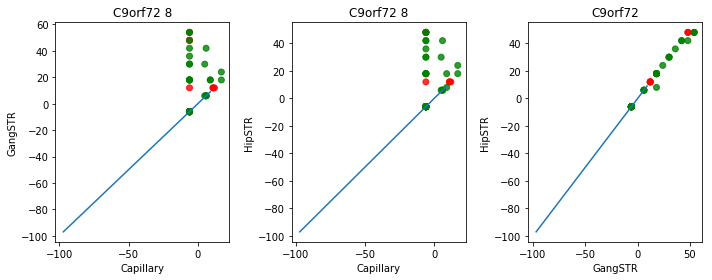

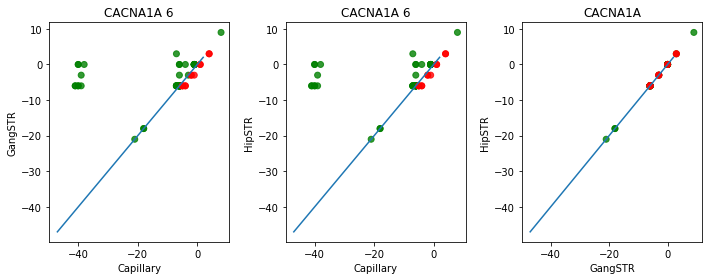

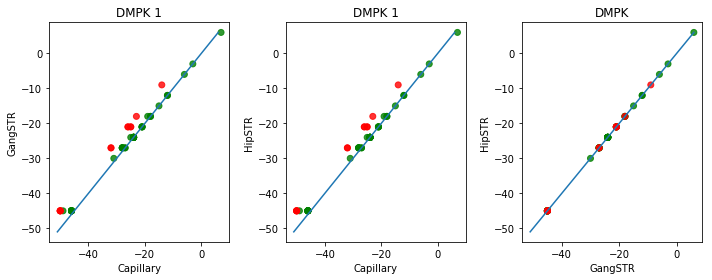

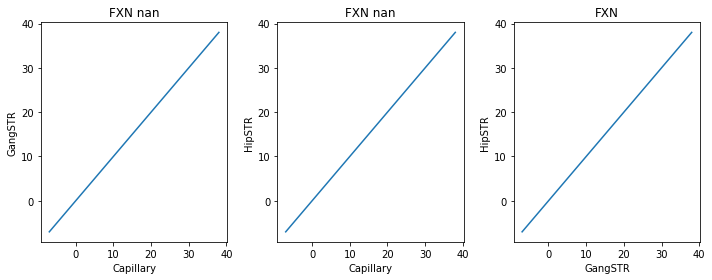

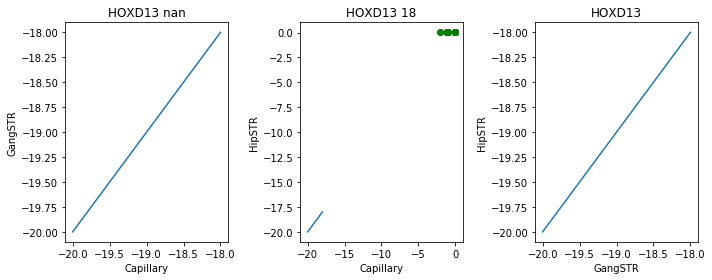

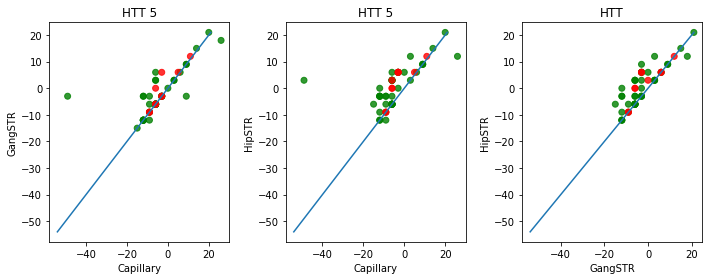

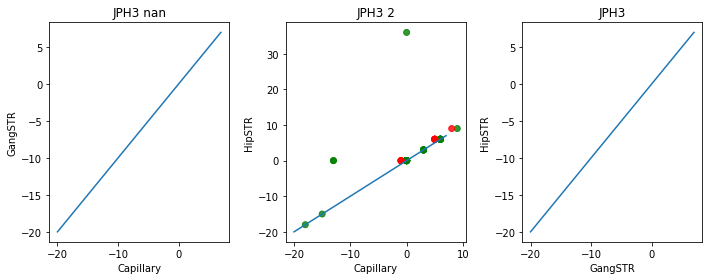

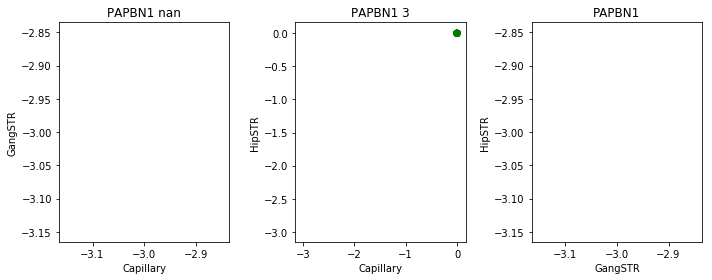

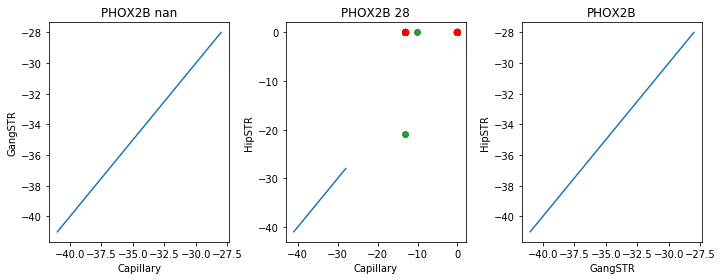

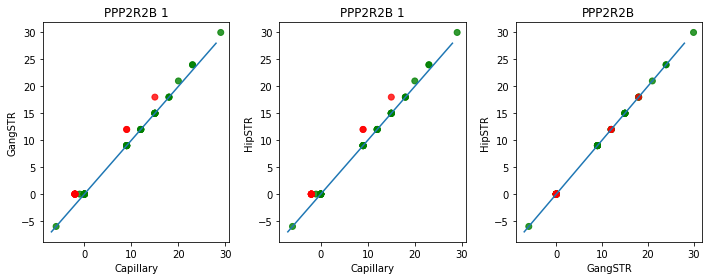

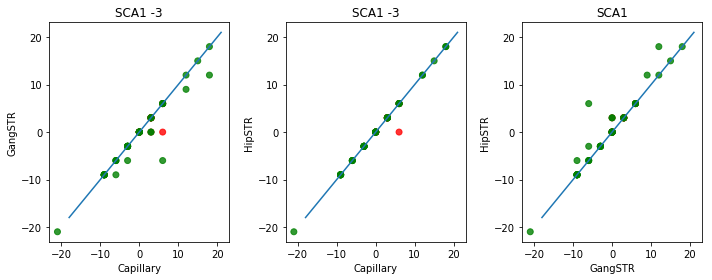

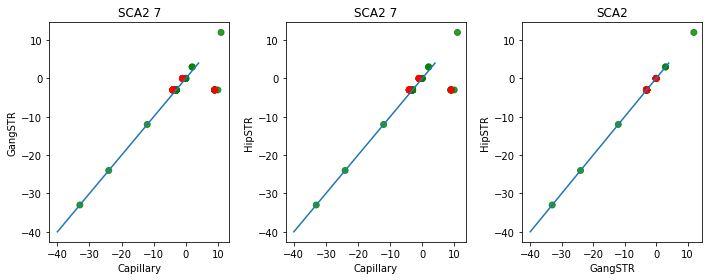

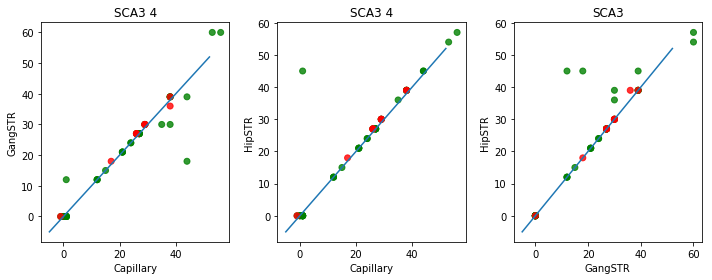

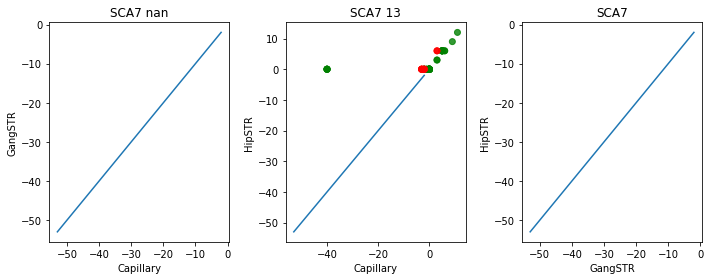

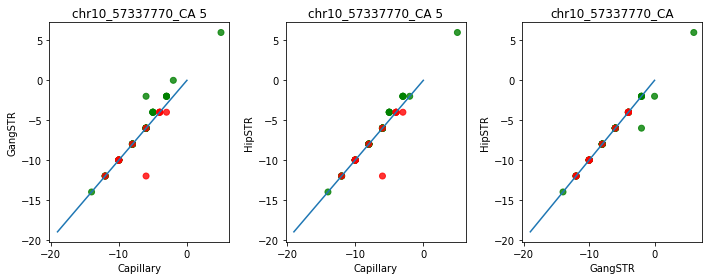

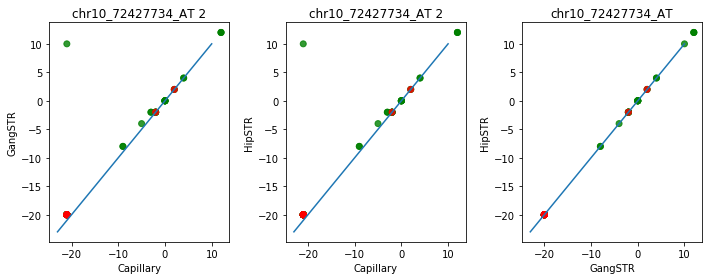

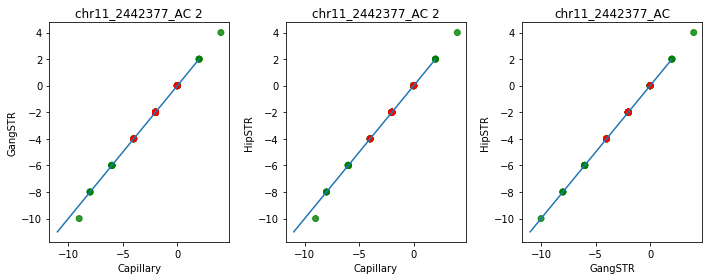

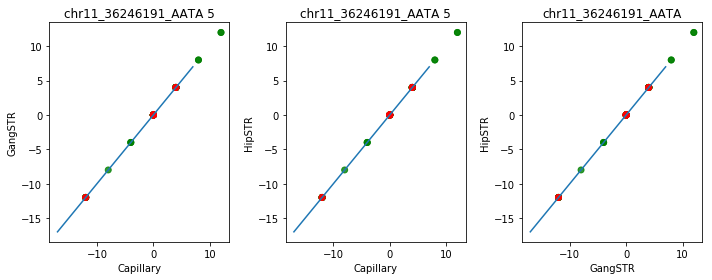

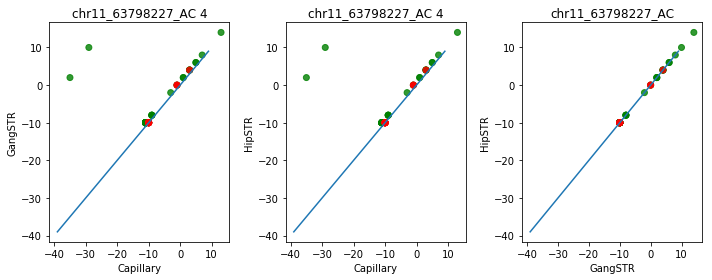

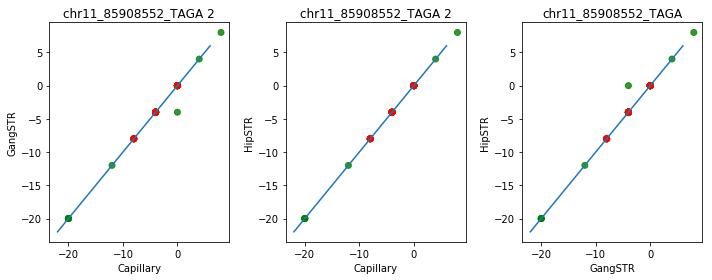

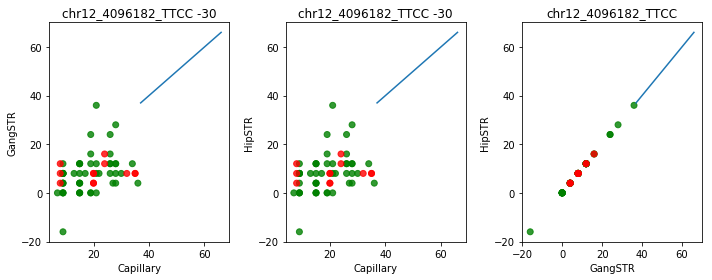

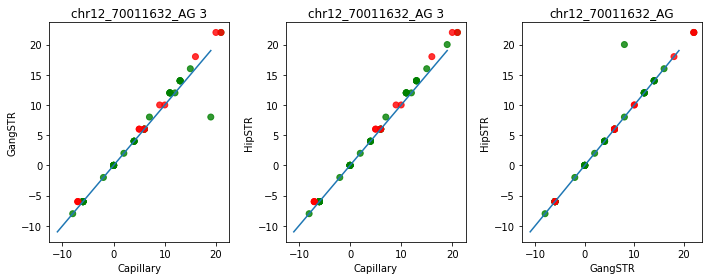

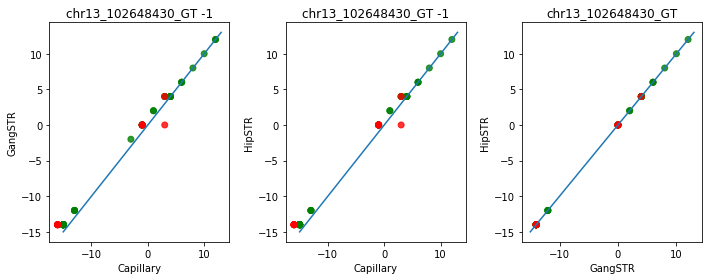

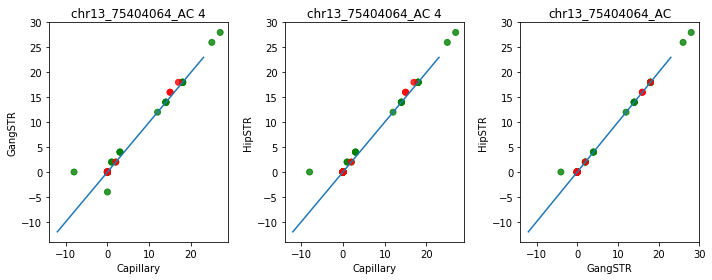

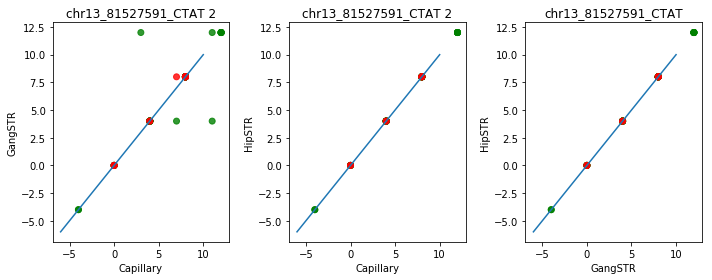

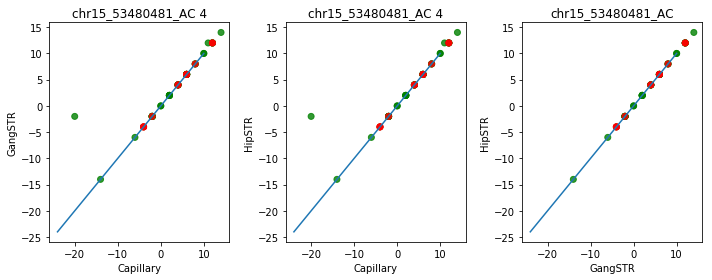

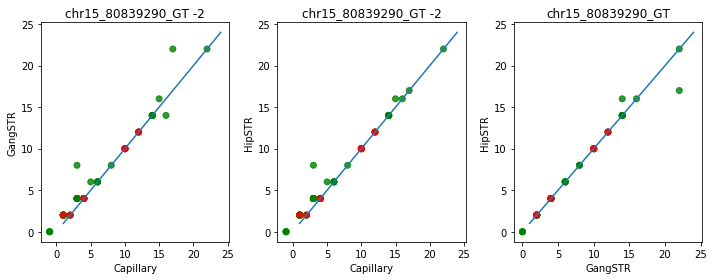

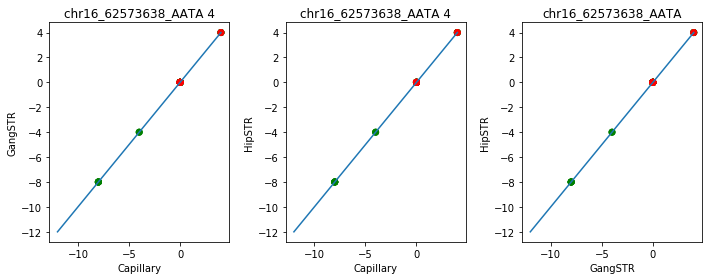

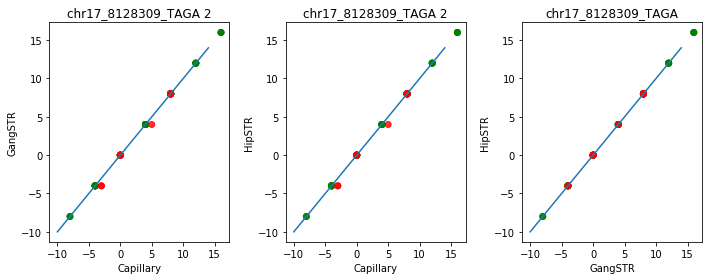

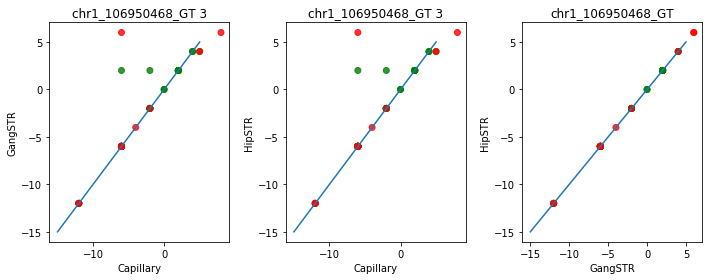

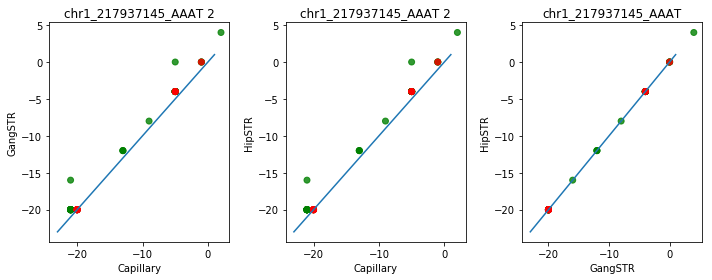

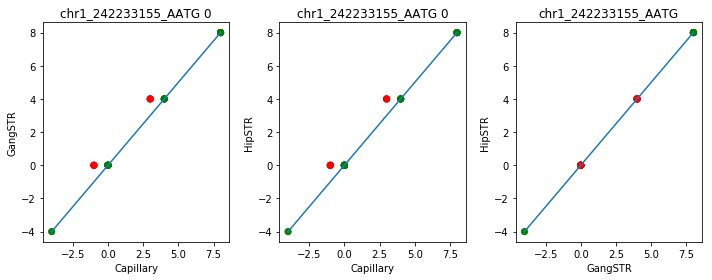

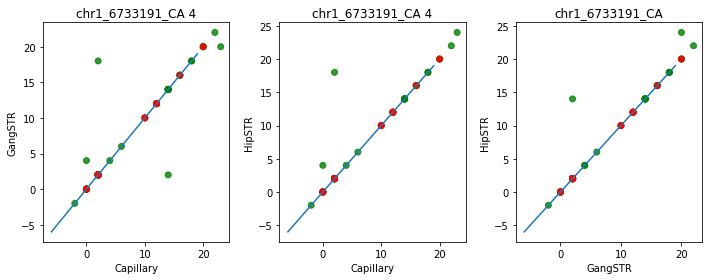

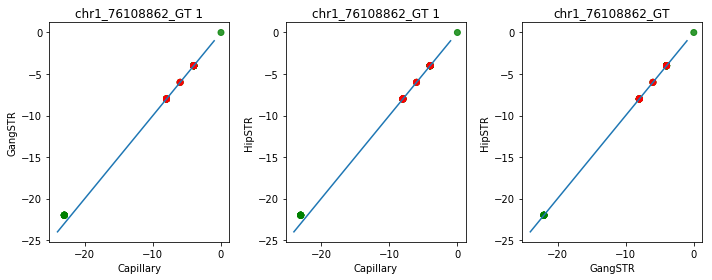

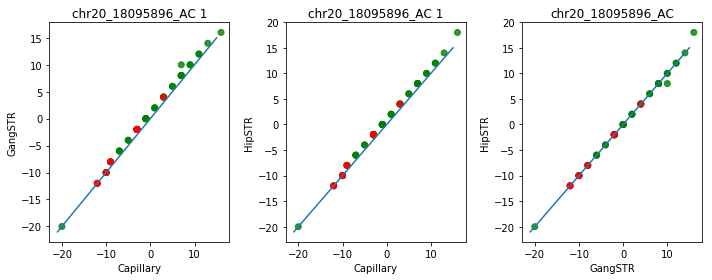

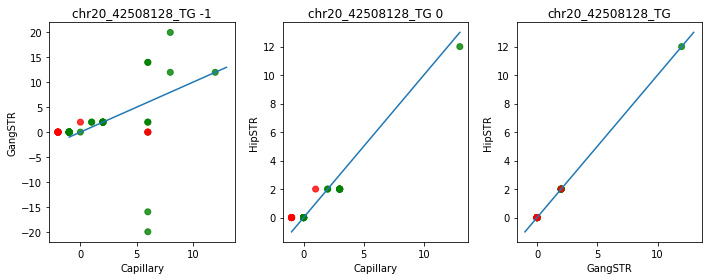

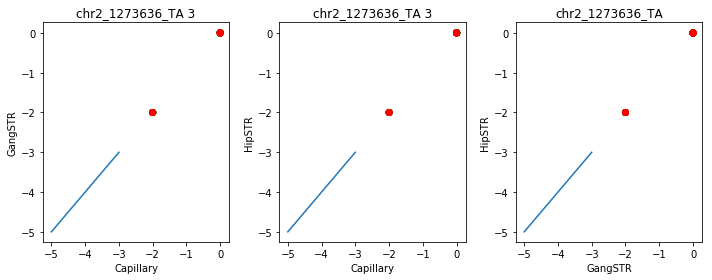

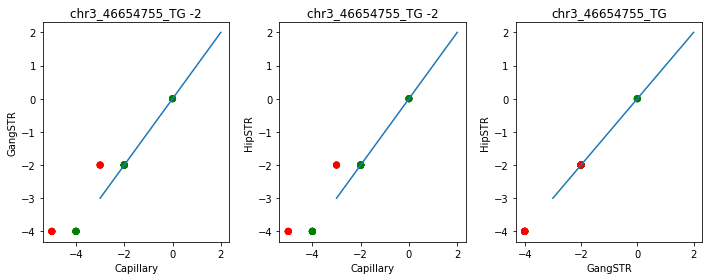

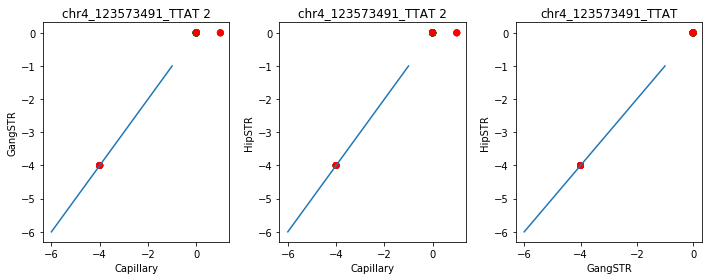

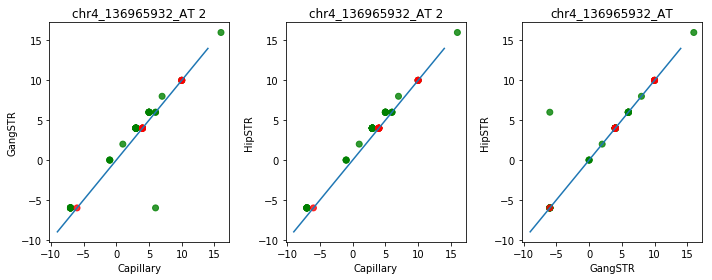

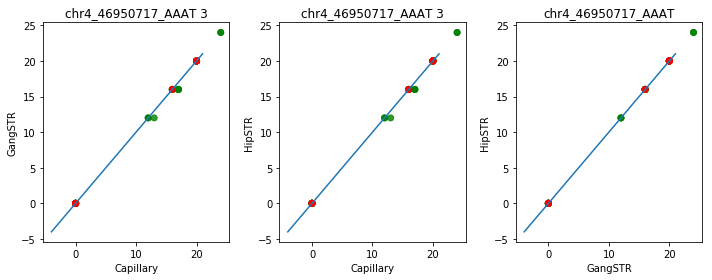

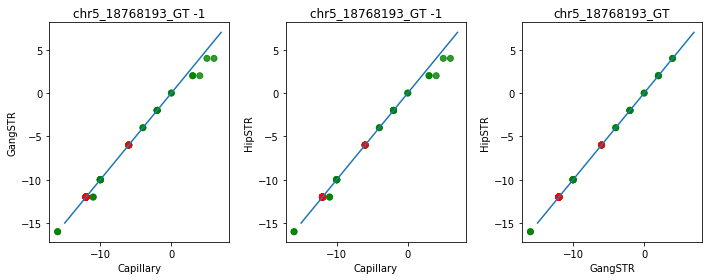

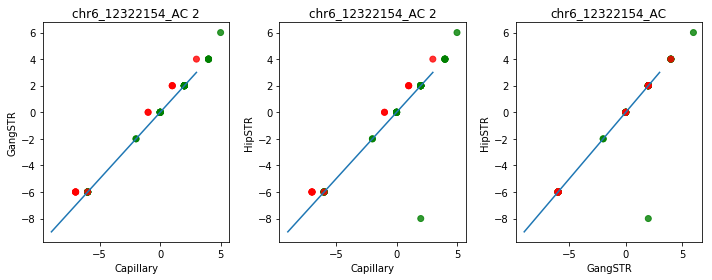

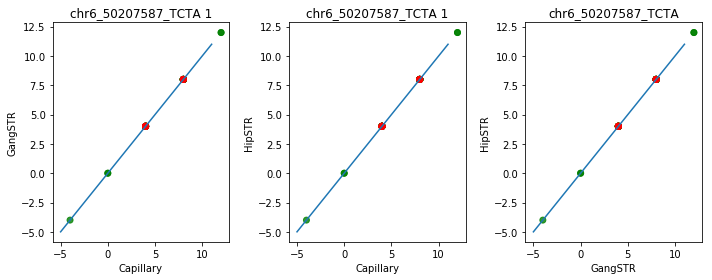

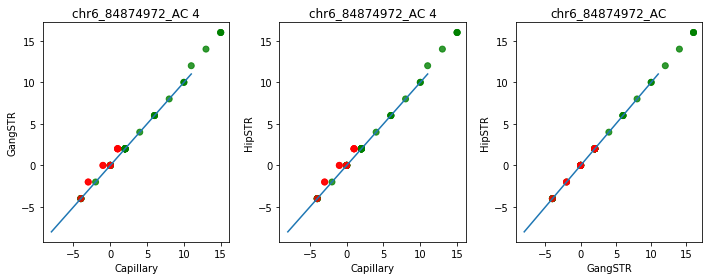

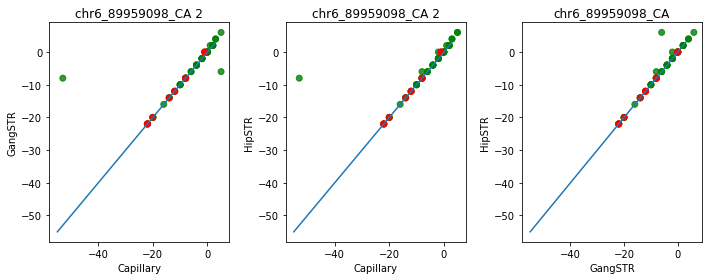

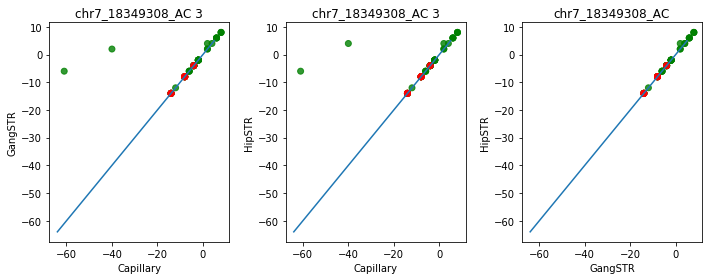

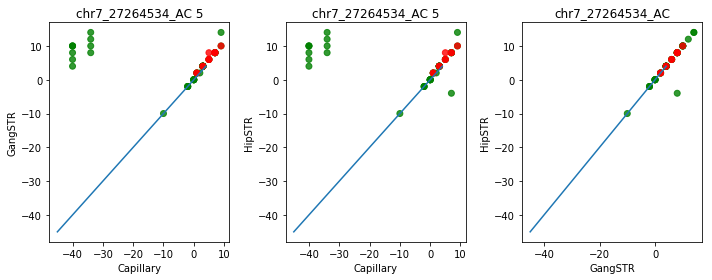

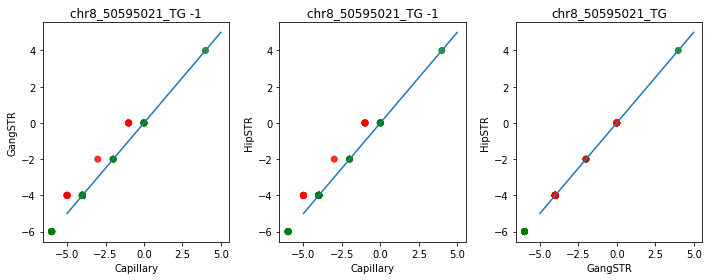

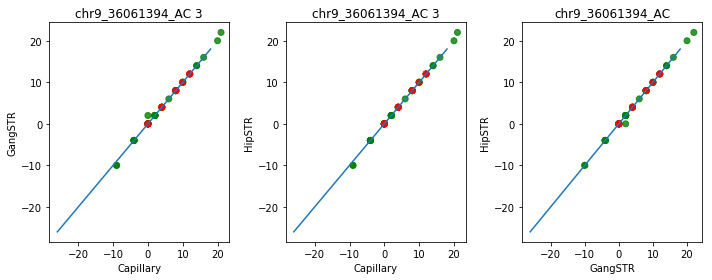

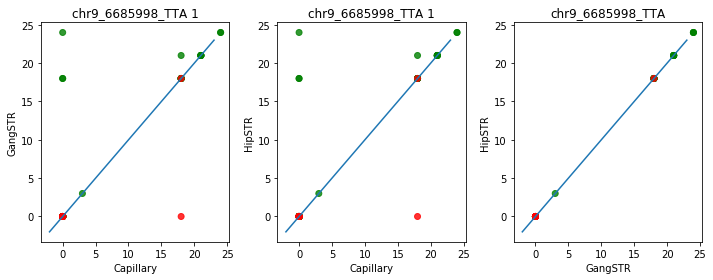

In [179]:
# Y = X + offset
def find_offset (X, Y, period):
    newX = [X[i] for i in range(len(X)) if not np.isnan(Y[i])]
    newY = [item for item in Y if not np.isnan(item)]
    
    if len(newX) == 0: return np.nan, np.nan, np.nan
    # measure: diffs in sizes
    most_matches = -10
    best_diffs = 100000
    best_offset = -1000
    for offset in range(-30,30):
        x_plus_off = [x + offset for x in newX]
        
        # Get matches after round to nearest repeat unit
        rounded_x = [round(item/period) for item in x_plus_off]
        rounded_y = [round(item/period) for item in newY]
        num_matches = sum(np.equal(rounded_x, rounded_y))
        
        # Get diffs. Take top %percentile since we don't know how many calls are wrong
        diffs = [abs(x_plus_off[i]-newY[i]) for i in range(len(x_plus_off))]
        diff = np.max(sorted(diffs)[0:10]) #np.median(diffs)
        
        if diff < best_diffs:
            best_diffs = diff
            best_offset = offset
            most_matches = num_matches
    return best_offset, most_matches, best_diffs

# Overall offset. also try to learn separately
offsets = []
offsets_PG = []
offsets_Coriell = []

# Data for call-level comparison
loci_ = []
samples_ = []
cap_ = []
hip_ = []
gang_ = []

for PrimerID in sorted(set(ref_prod_sizes["PrimerID"])):
    period = len(loci[loci["LocusID"]==PrimerID]["Motif"].values[0])
    ref_prod_size = ref_prod_sizes[ref_prod_sizes["PrimerID"]==PrimerID]["ProductSize"].values[0]    
    samp_loc_prod_sizes = samp_prod_sizes[samp_prod_sizes["PrimerID"]==PrimerID]
    
    X = [] # product size from capillary
    Y_gstr = [] # product size from gangstr
    Y_hstr = [] # product size from hipstr
    samples = [] # sample list

    allsamples = list(samp_loc_prod_sizes["SampleID"])

    for sample in allsamples:
        # Extract capillary data
        cap_prod_sizes = list(samp_loc_prod_sizes.set_index('SampleID').loc[sample][['prd_size_1', 'prd_size_2']])
        
        if "prd_size_1" in cap_prod_sizes: continue
        gb_cap = sorted([float(i) - float(ref_prod_size) for i in cap_prod_sizes])
        if sum(np.isnan(gb_cap)) > 0: continue 
        X.extend(gb_cap)
        samples.extend([sample]*2)

        # Extract gangstr and hipstr data
        try:
            gb_gstr = sorted([float(i) for i in gangstr_calls[PrimerID][sample]['gb'].split(',')])
        except: gb_gstr = [np.nan, np.nan]
        Y_gstr.extend(gb_gstr)
            
        try:
            gb_hstr = sorted([float(i) for i in hipstr_calls[PrimerID][sample]['gb'].split(',')])
        except:
            gb_hstr = [np.nan, np.nan]
        Y_hstr.extend(gb_hstr)  
        
    if len(X) == 0:
        offsets.append(np.nan)
        continue

    offset_gstr, num_matches_gstr, diff_gstr = find_offset(X, Y_gstr, period)
    offset_hstr, num_matches_hstr, diff_hstr = find_offset(X, Y_hstr, period)

    X_PG = [X[i] for i in range(len(X)) if sampcolors.get(samples[i], "gray")=="red"]
    Y_gstr_PG = [Y_gstr[i] for i in range(len(X)) if sampcolors.get(samples[i], "gray")=="red"]
    Y_hstr_PG = [Y_hstr[i] for i in range(len(X)) if sampcolors.get(samples[i], "gray")=="red"]
    offset_gstr_PG, num_matches_gstr_PG, diff_gstr_PG = find_offset(X_PG, Y_gstr_PG, period)
    offset_hstr_PG, num_matches_hstr_PG, diff_hstr_PG = find_offset(X_PG, Y_hstr_PG, period)

    X_Coriell = [X[i] for i in range(len(X)) if sampcolors.get(samples[i], "gray")=="green"]
    Y_gstr_Coriell = [Y_gstr[i] for i in range(len(X)) if sampcolors.get(samples[i], "gray")=="green"]
    Y_hstr_Coriell = [Y_hstr[i] for i in range(len(X)) if sampcolors.get(samples[i], "gray")=="green"]
    offset_gstr_Coriell, num_matches_gstr_Coriell, diff_gstr_Coriell = find_offset(X_Coriell, Y_gstr_Coriell, period)
    offset_hstr_Coriell, num_matches_hstr_Coriell, diff_hstr_Coriell = find_offset(X_Coriell, Y_hstr_Coriell, period)

    
    if not np.isnan(offset_hstr):
        offsets.append(offset_hstr)
        offsets_PG.append(offset_hstr_PG)
        offsets_Coriell.append(offset_hstr_Coriell)
    elif not np.isnan(offset_gstr):
        offsets.append(offset_gstr)
        offsets_PG.append(offset_gstr_PG)
        offsets_Coriell.append(offset_gstr_Coriell)
    else:
        offsets.append(np.nan)
        offsets_PG.append(np.nan)
        offsets_Coriell.append(np.nan)
        
    samp_offsets = []
    for sm in samples:
        if sampcolors.get(sm, "gray")=="red":
            samp_offsets.append(offsets_PG[-1])
        elif sampcolors.get(sm, "gray")=="green":
            samp_offsets.append(offsets_Coriell[-1])
        else: samp_offsets.append(np.nan)
            
    for i in range(0, len(X), 2):
        off = samp_offsets[i]
        if np.isnan(off): off = 0
        loci_.append(PrimerID)
        samples_.append(samples[i])
        cap_.append("%s,%s"%(int((X[i]+off)/period), int((X[i+1]+off)/period)))
        if not np.isnan(Y_hstr[i]):
            hip_.append("%s,%s"%(int(Y_hstr[i]/period), int(Y_hstr[i+1]/period)))
        else: hip_.append(".")
        if not np.isnan(Y_gstr[i]):
            gang_.append("%s,%s"%(int(Y_gstr[i]/period), int(Y_gstr[i+1]/period)))
        else: gang_.append(".")
        
    #print(f'\n>> {PrimerID} offset={offset_gstr}/{offset_hstr} nummatch={num_matches_gstr}/{num_matches_hstr}\n')
    colors = [sampcolors.get(sm,"gray") for sm in samples]
    xvals = [np.min(X), np.max(X)]
    fig = plt.figure()
    fig.set_size_inches((10, 4))
    ax = fig.add_subplot(131)
    ax.set_title(PrimerID + " %s"%offset_gstr)
    ax.set_xlabel("Capillary")
    ax.set_ylabel("GangSTR")
    ax.scatter([X[i]+samp_offsets[i] for i in range(len(X)item+offset_gstr for item in X], Y_gstr, alpha=0.8, color=colors)
    ax.plot(xvals, xvals)
    
    ax = fig.add_subplot(132)
    ax.set_title(PrimerID + " %s"%offset_hstr)
    ax.set_xlabel("Capillary")
    ax.set_ylabel("HipSTR")
    ax.scatter([item+offset_hstr for item in X], Y_hstr, alpha=0.8, color=colors)
    ax.plot(xvals, xvals)
    
    ax = fig.add_subplot(133)
    ax.set_title(PrimerID)
    ax.set_xlabel("GangSTR")
    ax.set_ylabel("HipSTR")
    ax.scatter(Y_gstr, Y_hstr, alpha=0.8, color=colors)
    ax.plot(xvals, xvals)

    fig.tight_layout()

ref_prod_sizes["Offset"] = offsets
ref_prod_sizes["Offset-PG"] = offsets_PG
ref_prod_sizes["Offset-Coriell"] = offsets_Coriell

calldata = pd.DataFrame({"PrimerID": loci_, "SampleID": samples_, "Cap": cap_, "HipSTR": hip_, "GangSTR": gang_})

In [180]:
ref_prod_sizes

,PrimerID,ProductSize,Offset,Offset-PG,Offset-Coriell
0,HOXD13,523,6.0,6.0,6.0
2,C9orf72,161,2.0,2.0,2.0
3,CACNA1A,159,8.0,29.0,8.0
4,ATN1,158,6.0,4.0,6.0
5,HTT,122,1.0,6.0,1.0
6,PAPBN1,263,NaN,NaN,NaN
7,JPH3,135,18.0,18.0,18.0
8,ATXN10,210,5.0,9.0,5.0
9,PPP2R2B,168,2.0,3.0,2.0
10,DMPK,909,3.0,3.0,3.0


In [181]:
calldata.to_csv("../data/csv/callcompare.txt", sep="\t")

In [182]:
############### Write matrix of product sizes ###########

psize_data = {} # PrimerID -> SampleID -> ProductSize
primer_ids = list(set(ref_prod_sizes["PrimerID"]))
primer_ids = [item for item in primer_ids if item not in rmloci]
samples = list(set(samp_prod_sizes["SampleID"]))

for pr in primer_ids:
    psize_data[pr] = {}
    psize_data[pr]["ref"] = ref_prod_sizes[ref_prod_sizes["PrimerID"]==pr]["ProductSize"].values[0]
    for sm in samples: psize_data[pr][sm] = "NA"
    
for i in range(samp_prod_sizes.shape[0]):
    pr = samp_prod_sizes["PrimerID"].values[i]
    if pr not in primer_ids: continue
    sm = samp_prod_sizes["SampleID"].values[i]
    prod = samp_prod_sizes["ProductSize"].values[i]
    psize_data[pr][sm] = prod

outf = open("../data/csv/psize_matrix.csv", "w")
outf.write(",".join(["PrimerID","RefProductSize"] + samples)+"\n")
for pr in primer_ids:
    items = [pr] + [psize_data[pr]["ref"]] + [psize_data[pr][sm] for sm in samples]
    outf.write(",".join([str(item) for item in items])+"\n")
outf.close()